In [9]:
# Imports, always include this at the beginning

# No science without NumPy
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# for pretty printing the model
from IPython.display import display, Markdown

# Of course we want Glotaran
import glotaran as gta

In [2]:
# Load the data
dataset = gta.io.TimeExplicitFile("data.ascii").read("dataset1")
data = dataset.get()
time_axis = dataset.get_time_axis()
spectral_axis = dataset.get_spectral_axis()


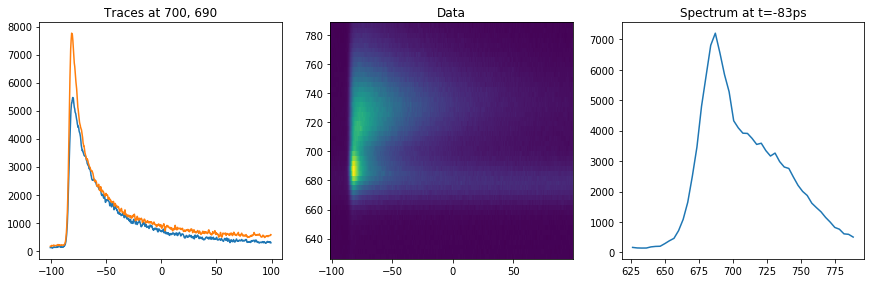

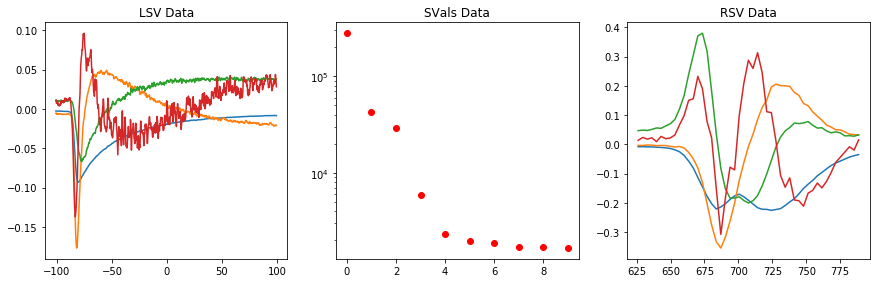

In [3]:
# Plot the Data

plt.figure(figsize=(20, 20))

# Plot some time traces
plt.subplot(4, 4, 1)
wl = [700, 690]
plt.title(f'Traces at {wl[0]}, {wl[1]}')
for w in wl:    
    plt.plot(time_axis, data[np.where(spectral_axis > w)[0][0], :])

# Full Data
plt.subplot(4, 4, 2)
plt.title('Data')
plt.pcolormesh(time_axis, spectral_axis, data)

# Plot the spectrum at time=-83
time_zero = -83
time_zero_idx = (np.abs(time_axis-time_zero)).argmin()
plt.subplot(4, 4, 3)
plt.title('Spectrum at t=-83ps')
plt.plot(spectral_axis, data[:, time_zero_idx])


plt.figure(figsize=(20, 20))

lsvd, svals, rsvd = dataset.svd()

# Plot left singular vectors (LSV, times, first 4)
plt.subplot(4, 4, 1)
plt.title('LSV Data')
plt.plot(time_axis, lsvd[:, :4])

# Plot singular values (SV)
plt.subplot(4, 4, 2)
plt.title('SVals Data')
n_svals = min(10, min(len(time_axis), len(spectral_axis)))
plt.plot(range(n_svals), svals[:n_svals], 'ro')
plt.yscale('log')

# Plot right singular vectors (RSV, wavelengths, first 4)
plt.subplot(4, 4, 3)
plt.title('RSV Data')
plt.plot(spectral_axis, rsvd[:, :4])

In [4]:
# Then we can create our model

model_spec = '''
type: kinetic
parameters:   
  - jvec:
    - [1, {vary: false}]
    - [0, {vary: false}]
    - [0, {vary: false}]
    - [0, {vary: false}]
  - irf:
    - ["center", -83.0]
    - ["width", 1.5]
    - [13200.0, "backsweep", {vary: false}]
  - kinetic:
    - 0.2
    - 0.07
    - 0.02
    - 0.00016
      
compartments: [s1, s2, s3, s4]

megacomplexes:
    - label: mc1
      k_matrices: [km1]
      
k_matrices:
  - label: "km1"
    matrix: {
      '("s2","s1")': kinetic.1,
      '("s3","s2")': kinetic.2,
      '("s4","s3")': kinetic.3,
      '("s4","s4")': kinetic.4
    }
    
irf:
  - label: irf
    type: gaussian
    center: irf.center
    width: irf.width
    backsweep: True
    backsweep_period: irf.backsweep

initial_concentrations: 
  - label: inputD1
    parameter: [jvec.0,jvec.1,jvec.2,jvec.3]
    
datasets:
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: ''
    irf: irf
    initial_concentrations: inputD1
'''

model = gta.parse(model_spec)
model.set_dataset("dataset1", dataset)
# print(model)
display(Markdown(str(model)))

# Model

_Type_: Kinetic

## Parameter
  * __jvec__:
    * __1__: _Value_: 1.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __2__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __3__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __4__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __irf__:
    * __center__: _Value_: -83.0, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __width__: _Value_: 1.5, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __backsweep__: _Value_: 13200.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __kinetic__:
    * __1__: _Value_: 0.2, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __2__: _Value_: 0.07, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __3__: _Value_: 0.02, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __4__: _Value_: 0.00016, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True


## Datasets

### _dataset1_

* _Dataset Scaling_: None
* _Initial Concentration_: None
* _Megacomplexes_: ['mc1']
* _Megacomplex Scalings_: None
* _Irf_: irf

## Compartments

* s1
* s2
* s3
* s4

## Megacomplexes

### _mc1_
* _K-Matrices_: ['km1']


## K-Matrices

### _km1_

compartment |    __s1__ |    __s2__ |    __s3__ |    __s4__ |
------------|-----------|-----------|-----------|-----------|
     __s1__ |           |           |           |           |
     __s2__ | kinetic.1 |           |           |           |
     __s3__ |           | kinetic.2 |           |           |
     __s4__ |           |           | kinetic.3 | kinetic.4 |

## IRFs

### _irf_
* _Type_: 'Gaussian'
* _Center_: ['irf.center']
* _Width_: ['irf.width']
* _Center Dispersion_: []
* _Width Dispersion_: []
* _Scale_: []
* _Nomalize_: True



In [5]:
result = model.fit()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4944e+08                                    2.79e+11    
       1              2         5.2271e+07      1.97e+08       7.12e-01       3.93e+10    
       2              3         4.4028e+07      8.24e+06       2.64e-01       6.02e+09    
       3              4         4.3754e+07      2.73e+05       2.24e-02       3.50e+08    
       4              5         4.3750e+07      4.45e+03       2.87e-03       4.63e+07    
       5              6         4.3750e+07      9.38e+01       3.25e-04       2.87e+06    
       6              7         4.3750e+07      2.29e+00       4.62e-05       1.74e+06    
       7              8         4.3750e+07      5.67e-02       7.44e-06       1.47e+05    
       8              9         4.3750e+07      1.41e-03       1.12e-06       4.17e+04    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 2.4944e+08

In [6]:
display(Markdown(str(result)))

# Fitresult

Optimization Result            |            |
-------------------------------|------------|
 Number of residual evaluation |          9 |
           Number of variables |          6 |
          Number of datapoints |      45227 |
            Negrees of freedom |      45221 |
                    Chi Square |87499627.089252 |
            Reduced Chi Square |1934.933484 |

## Best Fit Parameter

  * __jvec__:
    * __1__: _Value_: 1.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __2__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __3__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __4__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __irf__:
    * __center__: _Value_: -83.85334627112175, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __width__: _Value_: 1.6098574791696996, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __backsweep__: _Value_: 13200.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __kinetic__:
    * __1__: _Value_: 0.22498261025104901, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __2__: _Value_: 0.06806893158825433, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __3__: _Value_: 0.021225112069113504, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __4__: _Value_: 0.00015969281364260228, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True



hh


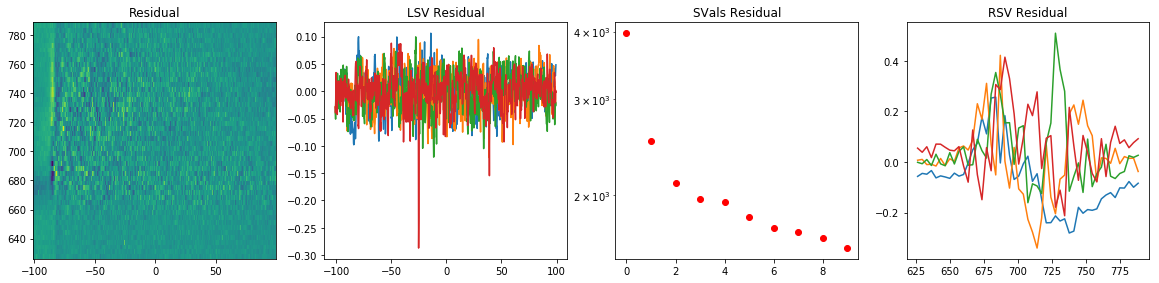

In [7]:
## Plot the fitted data

fitted_dataset = result.fitted_data('dataset1')
data = fitted_dataset.get()

plt.figure(figsize=(20, 20))

# Full Residual
plt.subplot(4, 4, 1)
plt.title('Residual')
plt.pcolormesh(time_axis, spectral_axis, result.final_residual())

residual_svd = result.final_residual_svd()
lsvd = residual_svd[2] 
svals = residual_svd[1]
rsvd = residual_svd[0] 

# Plot left singular vectors (LSV, times, first 4)
plt.subplot(4, 4, 2)
plt.title('LSV Residual')
plt.plot(time_axis, lsvd[:, range(4)])

# Plot singular values (SV)
plt.subplot(4, 4, 3)
plt.title('SVals Residual')
n_svals = min(10, min(len(time_axis), len(spectral_axis)))
plt.plot(range(n_svals), svals[:n_svals], 'ro')
plt.yscale('log')

# Plot right singular vectors (RSV, wavelengths, first 4)
plt.subplot(4, 4, 4)
plt.title('RSV Residual')
plt.plot(spectral_axis, rsvd[:, range(4)])

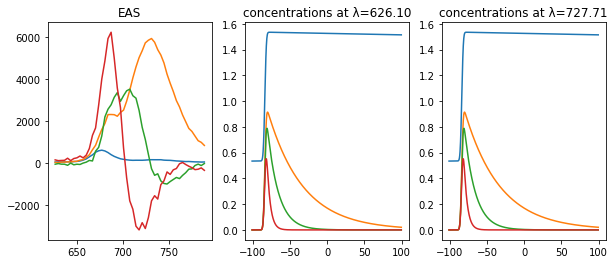

In [8]:
# Plotting the key results in the form of estimated spectra and corresponding concentrations
plt.figure(figsize=(10, 4))
spectra = result.e_matrix('dataset1')
spectra = np.asanyarray(spectra)  # TODO: this workaround should not be necessary
plt.subplot(1, 3, 1) 
plt.plot(spectral_axis, spectra)
plt.title('EAS');

concentrations = result.c_matrix('dataset1')
concentrations = np.asanyarray(concentrations)
# TODO: this np.asanyarray workaround should not be necessary
plt.subplot(1, 3, 2) 
plt.plot(time_axis, concentrations[0,:])
plt.title('concentrations at λ=%0.2f' % spectral_axis[0]);
# if we had dispersion plotting it at a different λ would result in different offset
plt.subplot(1, 3, 3) 
plt.plot(time_axis, concentrations[30,:])
plt.title('concentrations at λ=%0.2f' % spectral_axis[30]);